<a href="https://colab.research.google.com/github/grinaldo-oliveira/IC009---Pequenos-Experimentos/blob/main/LAB_PROCESSAMENTO_DE_IMAGEM_E_COR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🧪 Bloco de Pequenos Experimentos: Processamento de Imagens e Cor

Neste  bloco, exploraremos o uso de funções de intensidade, filtros de equalização, suavização e aguaçamento somre imagens. Também veremos a plotagem de histogramas para melhor compreender como as funções de intensidade impactam nos espaços de cor RGB, HSV e LAB.

---

#🧪 Experimento 1: Funções de Intensidade

## Plotagem de curvas e aplicação sobre uma imagem

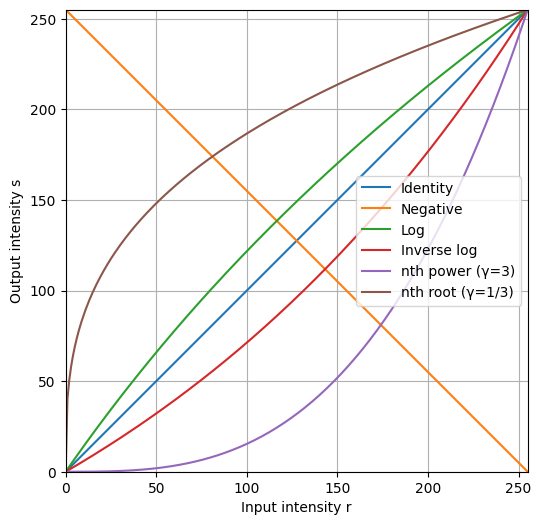

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Número de níveis de cinza
L = 256
r = np.linspace(0, L - 1, L)          # eixo de entrada (0 a L-1)
r_norm = r / (L - 1)                  # normalizado em [0,1]

# 1) Identidade
s_identity = r

# 2) Negativa: s = L-1-r
s_negative = (L - 1) - r

# 3) Log: s = c * log(1 + r_norm)
# usa log natural; c garante saída em [0, L-1]
c_log = (L - 1) / np.log(1 + 1)
s_log = c_log * np.log(1 + r_norm)

# 4) Log inverso aproximado: s = (exp(r_norm) - 1) normalizado
s_invlog = (np.exp(r_norm) - 1)
s_invlog = (L - 1) * s_invlog / s_invlog.max()

# 5) Potência (nth power): gamma > 1
gamma_power = 3.0
s_power = (L - 1) * (r_norm ** gamma_power)

# 6) Raiz (nth root): gamma < 1
gamma_root = 1.0 / 3.0
s_root = (L - 1) * (r_norm ** gamma_root)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(r, s_identity, label='Identity')
plt.plot(r, s_negative, label='Negative')
plt.plot(r, s_log, label='Log')
plt.plot(r, s_invlog, label='Inverse log')
plt.plot(r, s_power, label='nth power (γ=3)')
plt.plot(r, s_root, label='nth root (γ=1/3)')

plt.xlim(0, L - 1)
plt.ylim(0, L - 1)
plt.xlabel('Input intensity r')
plt.ylabel('Output intensity s')
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


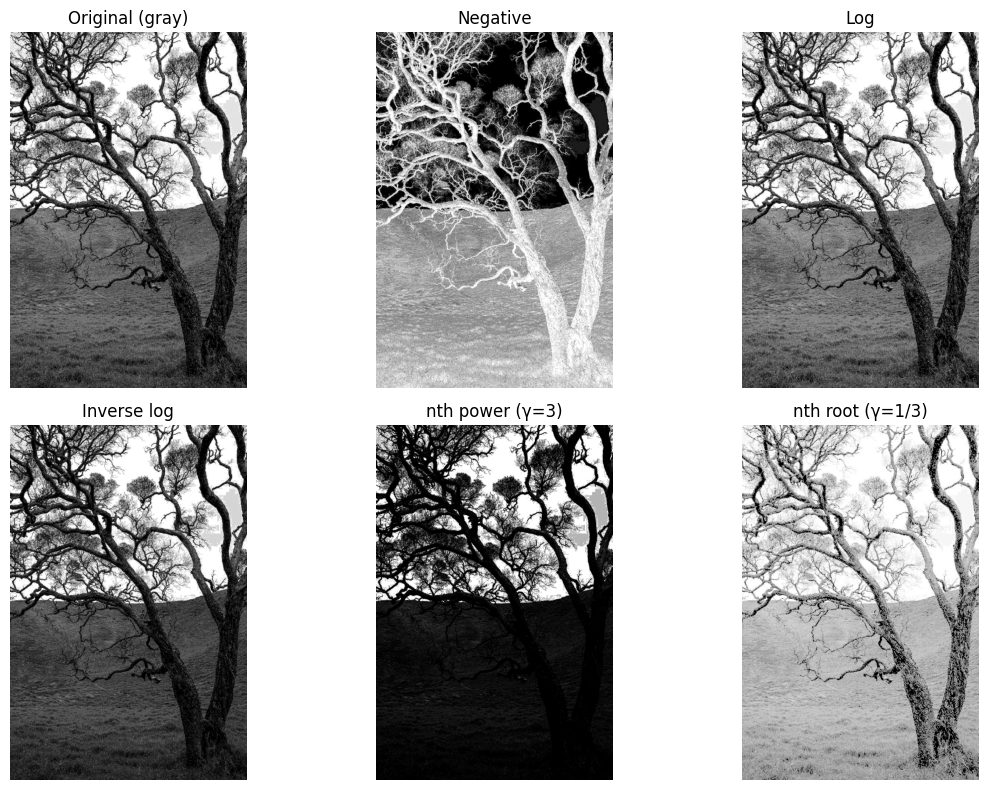

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float

# ---- carregar imagem de exemplo (cinza ou cor) ----
img = img_as_float(io.imread("/content/image_gray.png"))   # valores em [0,1]

# se for RGB, trabalhar na luminância simples (média) só para visualizar efeito
if img.ndim == 3:
    gray = img.mean(axis=2)
else:
    gray = img

# ---- funções de transformação ponto-a-ponto ----
def identity(r):
    return r

def negative(r):
    return 1.0 - r

def log_transform(r):
    # c = 1 / log(1 + 1) garante saída em [0,1]
    c = 1.0 / np.log(1 + 1)
    return c * np.log(1 + r)

def inverse_log_transform(r):
    s = np.exp(r) - 1
    s = s / s.max()
    return s

def power_law(r, gamma):
    return np.clip(r ** gamma, 0, 1)

# ---- aplicar transformações ----
img_identity = identity(gray)
img_negative = negative(gray)
img_log = log_transform(gray)
img_invlog = inverse_log_transform(gray)
img_power = power_law(gray, gamma=3.0)     # nth power
img_root = power_law(gray, gamma=1/3.0)    # nth root

# ---- mostrar resultados ----
titles = [
    "Original (gray)",
    "Negative",
    "Log",
    "Inverse log",
    "nth power (γ=3)",
    "nth root (γ=1/3)",
]

images = [gray, img_negative, img_log, img_invlog, img_power, img_root]

plt.figure(figsize=(12, 8))
for i, (im, t) in enumerate(zip(images, titles), 1):
    plt.subplot(2, 3, i)
    plt.imshow(im, cmap="gray", vmin=0, vmax=1)
    plt.title(t)
    plt.axis("off")

plt.tight_layout()
plt.show()


#🧪 Experimento 2: Equalização de uma imagem

## Recorte da equalização e visualização de histograma

=== Amostra de Pixels ===
  Posição  Original  Equalizado
 (21,170)       227         225
    (0,2)       170         193
(183,323)        57          73
(159,218)       198         204
(504,131)       142         184
(641,223)        57          73
 (80,133)       170         193
(368,179)       113         172
 (307,54)        85         130
(422,141)        85         130


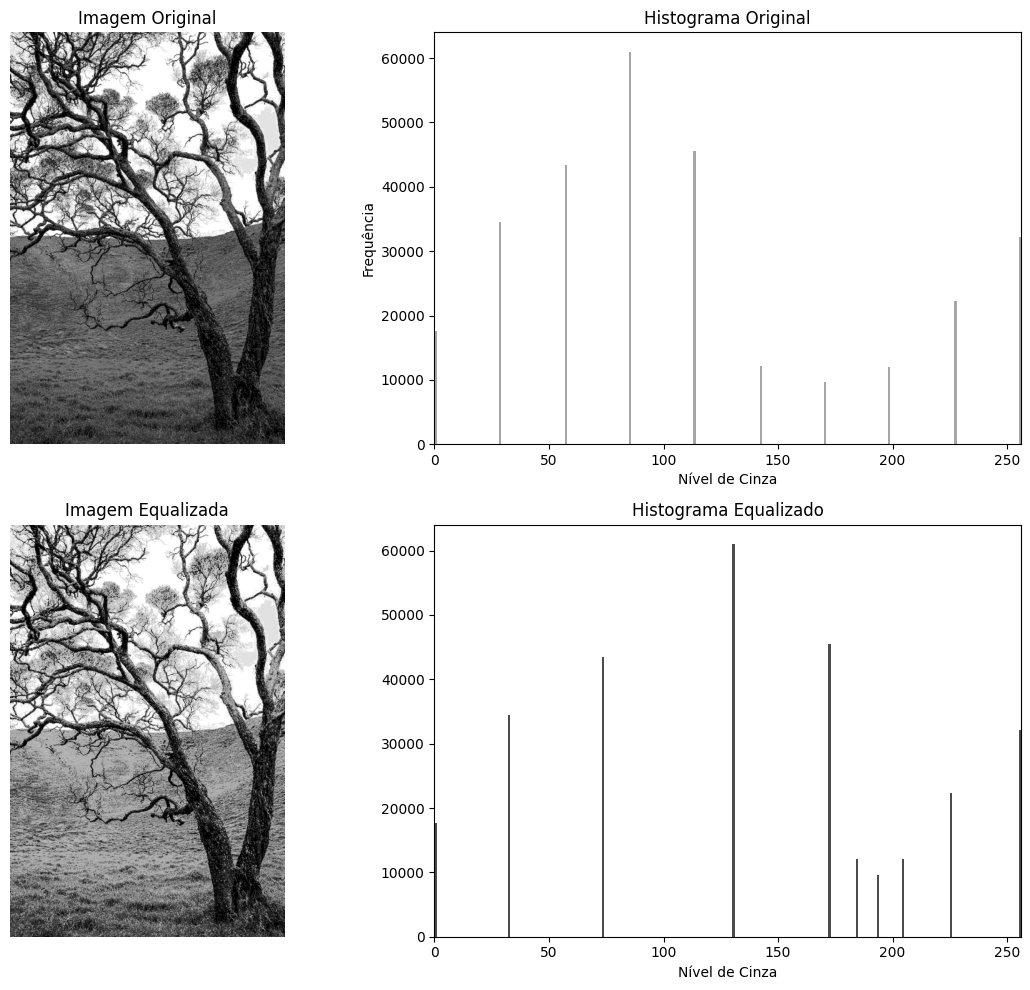

In [4]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def equalizacao_e_plotagem(imagem_caminho):
    # 1. Ler a imagem
    img = cv2.imread(imagem_caminho, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Erro ao ler imagem.")
        return

    # Dimensões e parâmetros
    altura, largura = img.shape
    total_pixels = altura * largura
    L = 256

    # 2. Calcular Histograma e CDF (Manualmente)
    histograma = np.zeros(L, dtype=int)
    for v in range(L):
        histograma[v] = np.sum(img == v)

    cdf = np.zeros(L, dtype=int)
    cdf[0] = histograma[0]
    for i in range(1, L):
        cdf[i] = cdf[i-1] + histograma[i]

    # 3. Aplicar Fórmula de Equalização
    cdf_min = cdf[cdf > 0].min()
    mapa_transformacao = np.zeros(L, dtype=np.uint8)

    for v in range(L):
        # Fórmula: h(v) = round( (cdf(v) - cdf_min)/(Total - cdf_min) * (L-1) )
        novo_valor = round(((cdf[v] - cdf_min) / (total_pixels - cdf_min)) * (L - 1))

        # Clip para garantir intervalo [0, 255]
        if novo_valor < 0: novo_valor = 0
        if novo_valor > 255: novo_valor = 255

        mapa_transformacao[v] = novo_valor

    # Aplicar a transformação
    img_equalizada = mapa_transformacao[img]

    # 4. Tabela de Comparação (Amostra de 10 pixels)
    indices_y = np.random.randint(0, altura, 10)
    indices_x = np.random.randint(0, largura, 10)
    dados = []
    for y, x in zip(indices_y, indices_x):
        dados.append({
            "Posição": f"({y},{x})",
            "Original": img[y, x],
            "Equalizado": img_equalizada[y, x]
        })

    print("=== Amostra de Pixels ===")
    print(pd.DataFrame(dados).to_string(index=False))

    # 5. Plotagem dos Histogramas e Imagens
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Imagem Original
    axs[0, 0].imshow(img, cmap='gray', vmin=0, vmax=255)
    axs[0, 0].set_title("Imagem Original")
    axs[0, 0].axis('off')

    # Histograma Original
    # ravel() transforma a matriz 2D em vetor 1D para o histograma
    axs[0, 1].hist(img.ravel(), bins=256, range=[0, 256], color='gray', alpha=0.7)
    axs[0, 1].set_title("Histograma Original")
    axs[0, 1].set_xlim([0, 256])
    axs[0, 1].set_xlabel("Nível de Cinza")
    axs[0, 1].set_ylabel("Frequência")

    # Imagem Equalizada
    axs[1, 0].imshow(img_equalizada, cmap='gray', vmin=0, vmax=255)
    axs[1, 0].set_title("Imagem Equalizada")
    axs[1, 0].axis('off')

    # Histograma Equalizado
    axs[1, 1].hist(img_equalizada.ravel(), bins=256, range=[0, 256], color='black', alpha=0.7)
    axs[1, 1].set_title("Histograma Equalizado")
    axs[1, 1].set_xlim([0, 256])
    axs[1, 1].set_xlabel("Nível de Cinza")

    plt.tight_layout()
    plt.show()

# Exemplo de uso:
equalizacao_e_plotagem('/content/image_gray.png')

#🧪 Experimento 3: Filtros de Suavização e Aguaçamento

## Aplicação experimental de kernels diferentes

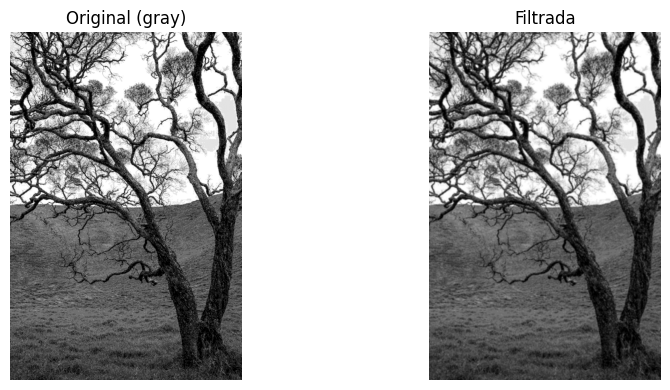

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage  # pip install scipy

# -------- 1) Carregar imagem (você escolhe o arquivo) --------
# Use uma PNG em tons de cinza ou RGB
img = Image.open("/content/image_gray.png")

# Converte para escala de cinza para simplificar
img_gray = img.convert("L")          # "L" = 8 bits grayscale
img_arr = np.array(img_gray, dtype=float)

# -------- 2) Definir um kernel 3x3 (você altera aqui) --------
# Exemplo: média 3x3 (suavização)
#kernel = (1/9.0) * np.array([[1, 1, 1],
#                             [1, 1, 1],
#                             [1, 1, 1]])

kernel = (1/16.0) * np.array([[1, 2, 1],
                             [2, 4, 2],
                             [1, 2, 1]])


# Outros exemplos: basta descomentar / editar

# Sharpen:
#kernel = np.array([[0, -1,  0],
#                   [-1, 5, -1],
#                   [0, -1,  0]])

# Sobel horizontal:
#kernel = np.array([[-1, -2, -1],
#                    [ 0,  0,  0],
#                    [ 1,  2,  1]])

# -------- 3) Aplicar convolução --------
# mode='reflect' trata bordas refletindo a imagem
filtered = ndimage.convolve(img_arr, kernel, mode="reflect")

# Normaliza para faixa 0–255 e converte para uint8
filtered = np.clip(filtered, 0, 255)
filtered = filtered.astype(np.uint8)

# -------- 4) Visualizar resultado --------
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original (gray)")
plt.imshow(img_arr, cmap="gray", vmin=0, vmax=255)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Filtrada")
plt.imshow(filtered, cmap="gray", vmin=0, vmax=255)
plt.axis("off")

plt.tight_layout()
plt.show()


#🧪 Experimento 4: Espaços de Cor

## Aplicação de funções de intensidade e avaliação de histogramas

Processamento concluído. Gerando visualização...


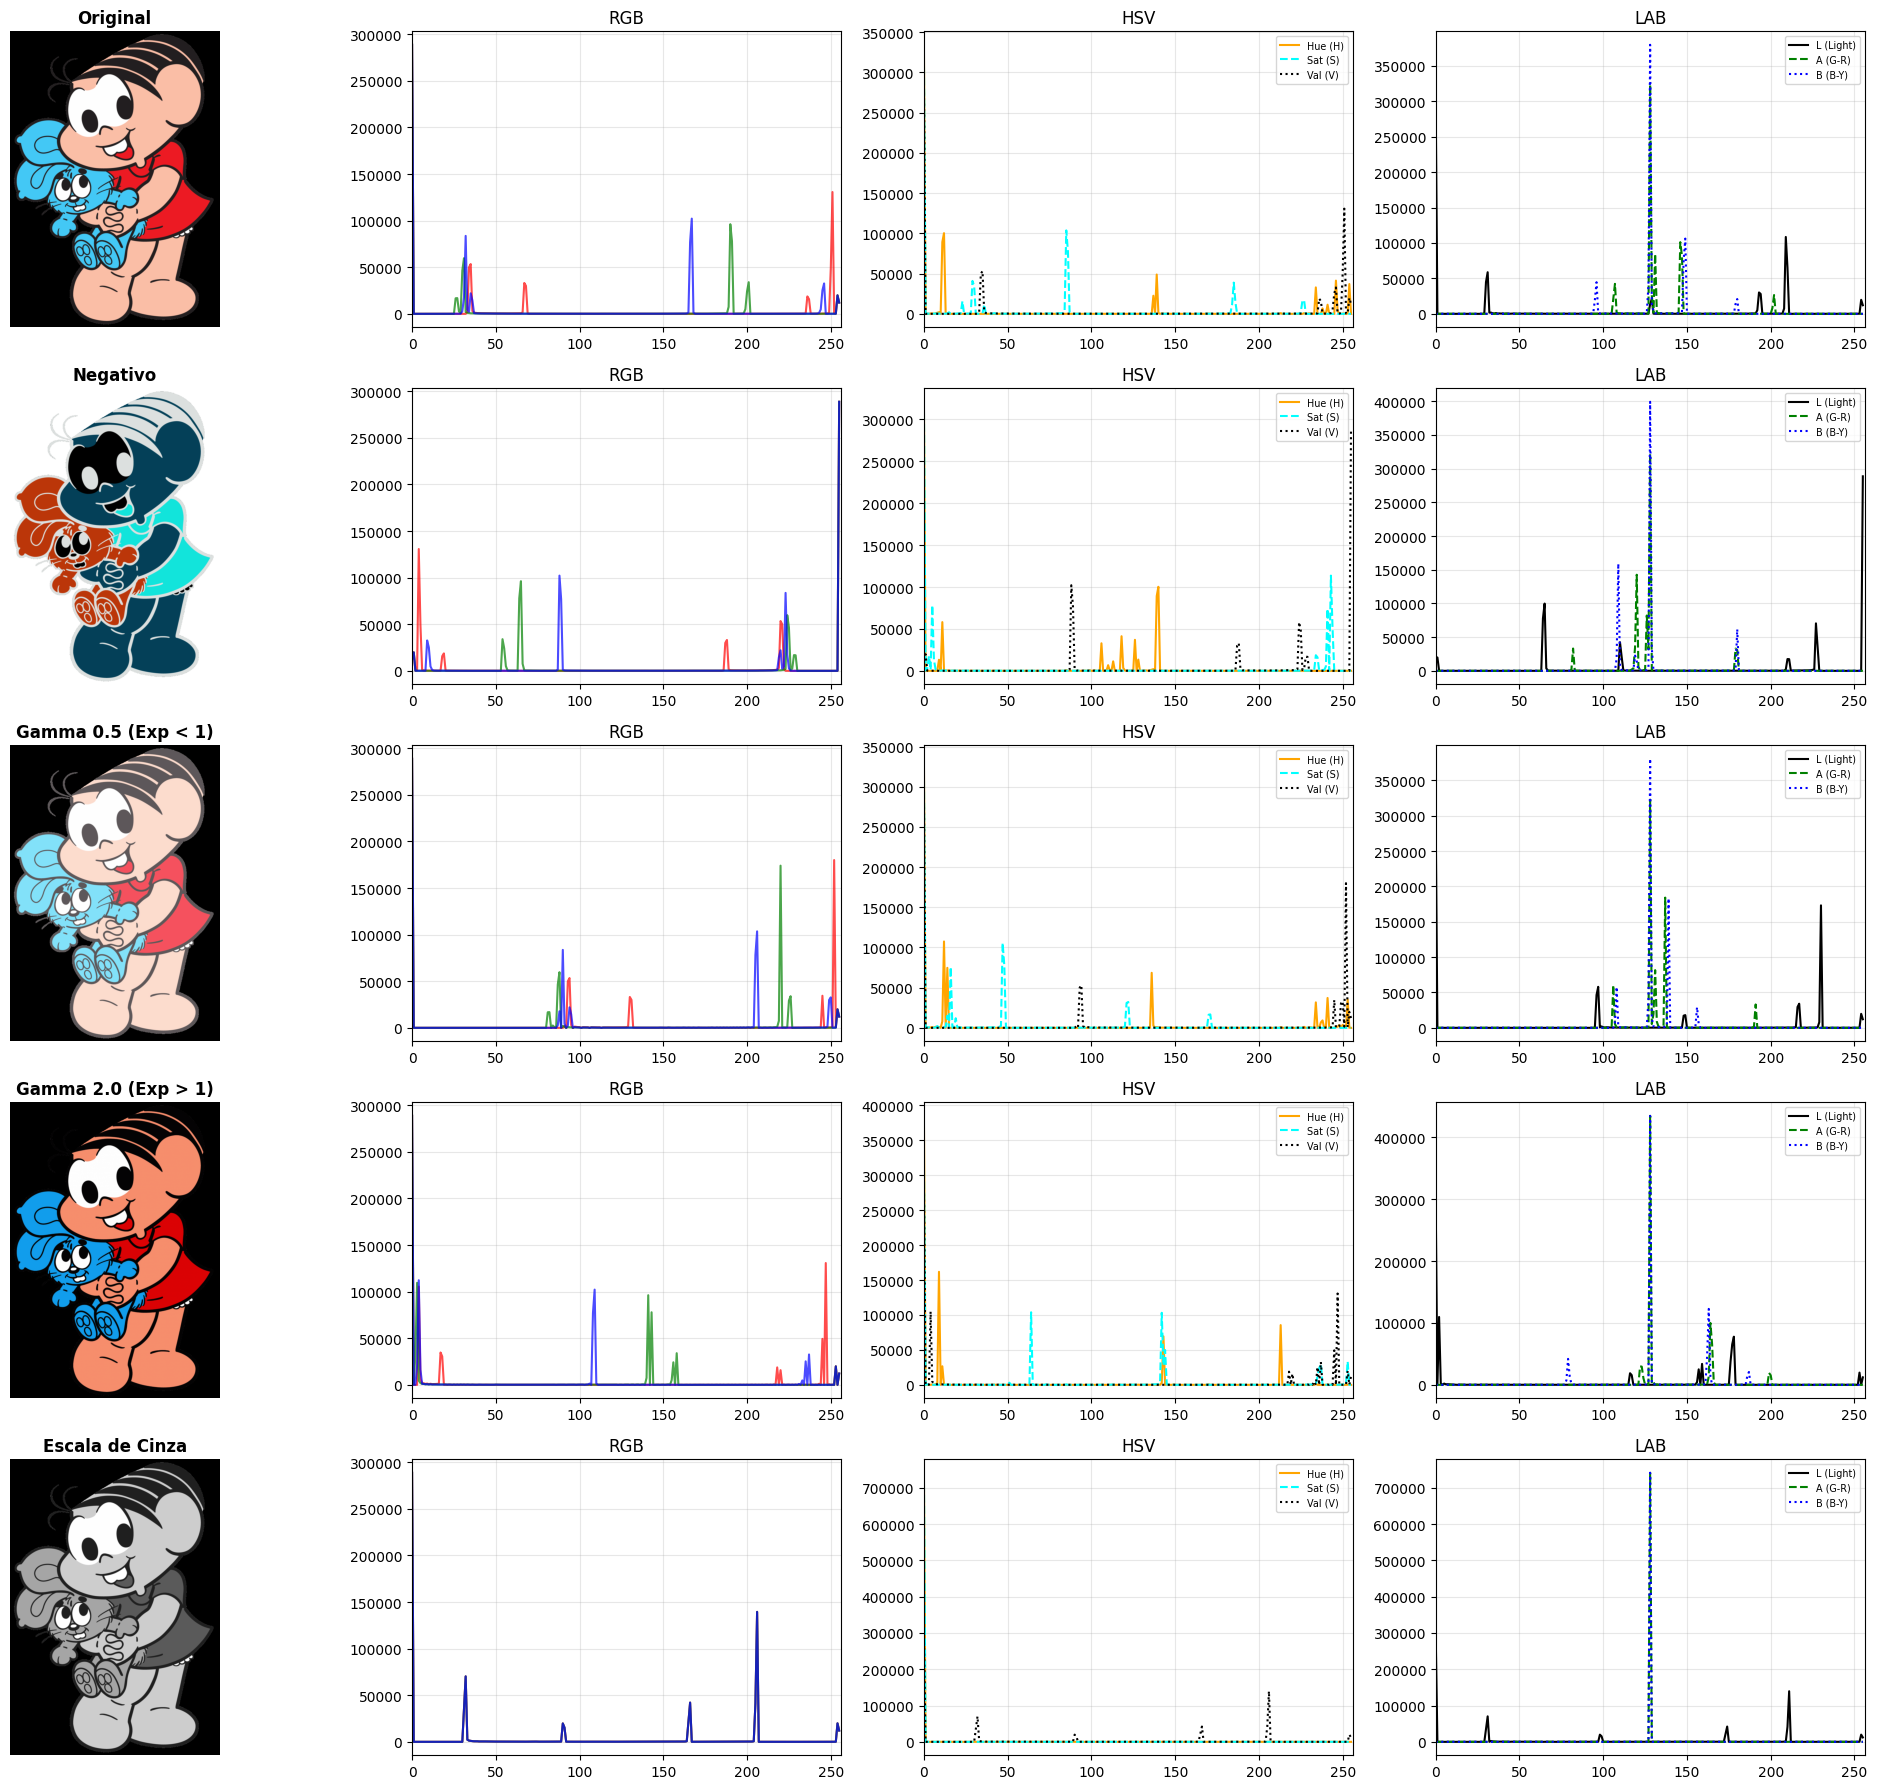

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def aplicar_gamma(imagem, gamma=1.0):
    """
    Aplica correção gamma (exponenciação).
    Lógica: O = ((I / 255) ^ gamma) * 255
    """
    invGamma = gamma # Se a entrada for o valor direto do expoente

    # Criar Lookup Table (LUT) para ser mais rápido
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")

    # Aplica a LUT na imagem
    return cv2.LUT(imagem, table)

def calcular_plotar_histogramas(ax_hists, img_rgb, titulo_prefixo):
    """
    Calcula e plota os histogramas RGB, HSV e LAB nas posições indicadas.
    img_rgb: Imagem já em formato RGB (para matplotlib e conversões)
    """

    # --- 1. Histograma RGB ---
    cores_rgb = ('r', 'g', 'b')
    ax_hists[0].set_title(f"RGB")
    for i, cor in enumerate(cores_rgb):
        # Calcula hist do canal i
        hist = cv2.calcHist([img_rgb], [i], None, [256], [0, 256])
        ax_hists[0].plot(hist, color=cor, alpha=0.7)
    ax_hists[0].set_xlim([0, 256])
    ax_hists[0].grid(alpha=0.3)

    # --- 2. Histograma HSV ---
    # Converter para HSV
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    # H (Hue) - Cor, S (Saturation) - Linha tracejada, V (Value) - Linha pontilhada
    labels_hsv = [('Hue (H)', 'orange', '-'), ('Sat (S)', 'cyan', '--'), ('Val (V)', 'black', ':')]

    ax_hists[1].set_title(f"HSV")
    for i, (label, cor, estilo) in enumerate(labels_hsv):
        # Nota: Hue no OpenCV vai de 0-179, S e V 0-255
        faixa = [0, 180] if i == 0 else [0, 256]
        hist = cv2.calcHist([img_hsv], [i], None, [256], faixa)
        ax_hists[1].plot(hist, color=cor, linestyle=estilo, label=label)
    ax_hists[1].set_xlim([0, 256])
    ax_hists[1].legend(fontsize='x-small')
    ax_hists[1].grid(alpha=0.3)

    # --- 3. Histograma LAB ---
    # Converter para LAB
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    labels_lab = [('L (Light)', 'black', '-'), ('A (G-R)', 'green', '--'), ('B (B-Y)', 'blue', ':')]

    ax_hists[2].set_title(f"LAB")
    for i, (label, cor, estilo) in enumerate(labels_lab):
        hist = cv2.calcHist([img_lab], [i], None, [256], [0, 256])
        ax_hists[2].plot(hist, color=cor, linestyle=estilo, label=label)
    ax_hists[2].set_xlim([0, 256])
    ax_hists[2].legend(fontsize='x-small')
    ax_hists[2].grid(alpha=0.3)

def processar_imagem_completa(caminho_imagem):
    # 1. Carregar imagem original
    img_bgr = cv2.imread(caminho_imagem)
    if img_bgr is None:
        print("Erro: Imagem não encontrada.")
        return

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 2. Gerar as variações
    # A) Negativo (255 - pixel)
    img_negativo = 255 - img_rgb

    # B) Exponenciação < 1 (Clareia) - Gamma 0.5
    img_gamma_low = aplicar_gamma(img_rgb, gamma=0.5)

    # C) Exponenciação > 1 (Escurece) - Gamma 2.0
    img_gamma_high = aplicar_gamma(img_rgb, gamma=2.0)

    # D) Escala de Cinza
    # Convertemos para cinza e depois voltamos para RGB apenas para manter
    # a consistência das dimensões na plotagem e cálculo de hist (R=G=B)
    img_gray_1ch = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    img_gray = cv2.cvtColor(img_gray_1ch, cv2.COLOR_GRAY2RGB)

    # Lista de tarefas para iterar
    tarefas = [
        ("Original", img_rgb),
        ("Negativo", img_negativo),
        ("Gamma 0.5 (Exp < 1)", img_gamma_low),
        ("Gamma 2.0 (Exp > 1)", img_gamma_high),
        ("Escala de Cinza", img_gray)
    ]

    # 3. Configurar Plotagem (5 linhas x 4 colunas)
    # Coluna 0: Imagem | Coluna 1: Hist RGB | Coluna 2: Hist HSV | Coluna 3: Hist LAB
    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 18))

    # Ajuste de layout
    plt.subplots_adjust(hspace=0.6, wspace=0.3)

    for linha_idx, (titulo, imagem) in enumerate(tarefas):
        # Coluna 0: Exibir a Imagem
        ax_img = axes[linha_idx, 0]
        ax_img.imshow(imagem, cmap='gray' if titulo == "Escala de Cinza" else None)
        ax_img.set_title(titulo, fontweight='bold')
        ax_img.axis('off')

        # Colunas 1, 2, 3: Histogramas
        # Passamos os eixos correspondentes para a função preencher
        eixos_hists = [axes[linha_idx, 1], axes[linha_idx, 2], axes[linha_idx, 3]]
        calcular_plotar_histogramas(eixos_hists, imagem, titulo)

    print("Processamento concluído. Gerando visualização...")
    plt.tight_layout()
    plt.show()

# --- EXECUÇÃO ---
# Substitua pelo nome da sua imagem
# Vou criar uma imagem de exemplo caso você não tenha uma
import os
if not os.path.exists('/content/imagem_colorida.png'):
    # Cria uma imagem gradiente colorida sintética para teste
    X = np.linspace(0, 1, 256)
    Y = np.linspace(0, 1, 256)
    X, Y = np.meshgrid(X, Y)
    R = (X * 255).astype(np.uint8)
    G = (Y * 255).astype(np.uint8)
    B = ((X+Y)/2 * 255).astype(np.uint8)
    img_synth = cv2.merge([B, G, R]) # OpenCV usa BGR
    cv2.imwrite('exemplo_colorido.jpg', img_synth)
    processar_imagem_completa('exemplo_colorido.jpg')
else:
    processar_imagem_completa('/content/imagem_colorida.png')